<a href="https://colab.research.google.com/github/Volodymyr301/enterprise-samples/blob/master/Practice_5_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting ZIP archive...
Extracting 101_ObjectCategories.tar.gz...
Loaded 300 images across 3 categories.


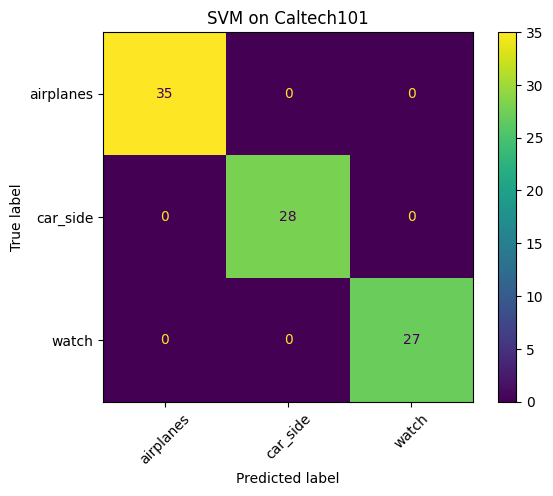

Accuracy for SVM on Caltech101: 1.0000
Classification Report:
              precision    recall  f1-score   support

   airplanes       1.00      1.00      1.00        35
    car_side       1.00      1.00      1.00        28
       watch       1.00      1.00      1.00        27

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



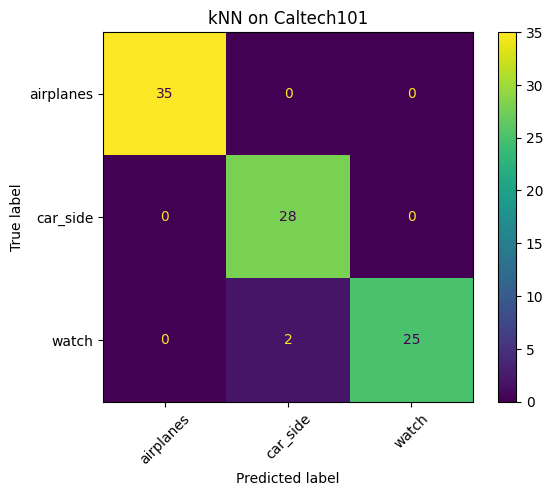

Accuracy for kNN on Caltech101: 0.9778
Classification Report:
              precision    recall  f1-score   support

   airplanes       1.00      1.00      1.00        35
    car_side       0.93      1.00      0.97        28
       watch       1.00      0.93      0.96        27

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



In [1]:
# Bag of Words classification pipeline

import os
import cv2
import zipfile
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage.feature import hog

# Define dataset paths and URLs
CALTECH_URL = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"
CALTECH_ZIP = "caltech-101.zip"
BASE_DIR = "caltech101"
TAR_FILE = os.path.join(BASE_DIR, "caltech-101", "101_ObjectCategories.tar.gz")
DATASET_PATH = os.path.join(BASE_DIR, "101_ObjectCategories")

# Step 1: Download and extract caltech-101.zip
def download_and_extract_caltech101():
    if not os.path.exists(TAR_FILE):
        print("Downloading caltech-101.zip...")
        urllib.request.urlretrieve(CALTECH_URL, CALTECH_ZIP)
        print("Extracting ZIP archive...")
        with zipfile.ZipFile(CALTECH_ZIP, 'r') as zip_ref:
            zip_ref.extractall(BASE_DIR)
    else:
        print("ZIP archive already extracted.")

# Step 2: Extract 101_ObjectCategories.tar.gz
def extract_tar_gz():
    if not os.path.exists(DATASET_PATH):
        print("Extracting 101_ObjectCategories.tar.gz...")
        with tarfile.open(TAR_FILE, "r:gz") as tar:
            tar.extractall(path=BASE_DIR)
    else:
        print("Image categories directory already extracted.")

# Execute extraction steps
download_and_extract_caltech101()
extract_tar_gz()

# Define categories and parameters
CATEGORIES = ['airplanes', 'car_side', 'faces', 'watch']
IMAGES_PER_CLASS = 100
IMAGE_SIZE = (128, 128)

# Load images and return actual loaded categories
def load_images():
    images = []
    labels = []
    actual_categories = []
    for idx, category in enumerate(CATEGORIES):
        files = glob(os.path.join(DATASET_PATH, category, '*.jpg'))[:IMAGES_PER_CLASS]
        if len(files) == 0:
            print(f"Warning: No images found for category '{category}'")
            continue
        actual_categories.append(category)
        for file in files:
            img = cv2.imread(file)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            images.append(img)
            labels.append(len(actual_categories) - 1)
    return np.array(images), np.array(labels), actual_categories

# Load dataset
images, labels, loaded_categories = load_images()
print(f"Loaded {len(images)} images across {len(loaded_categories)} categories.")

if len(images) == 0:
    raise ValueError("No images were loaded. Please check dataset path or content.")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Extract HOG features from images
def extract_hog_descriptors(images):
    descriptors = []
    for img in images:
        gray = rgb2gray(img)
        hog_features = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        descriptors.append(hog_features)
    return np.array(descriptors)

X_train_desc = extract_hog_descriptors(X_train)
X_test_desc = extract_hog_descriptors(X_test)

# Train KMeans on HOG descriptors
kmeans = KMeans(n_clusters=100, random_state=42)
kmeans.fit(X_train_desc)

# Build histogram of visual words
def compute_histogram(features):
    labels = kmeans.predict(features.reshape(1, -1))
    hist, _ = np.histogram(labels, bins=range(101), density=True)
    return hist

X_train_hist = np.array([compute_histogram(desc) for desc in X_train_desc])
X_test_hist = np.array([compute_histogram(desc) for desc in X_test_desc])

# Train classifiers
svm = SVC(kernel='linear')
svm.fit(X_train_hist, y_train)
y_pred_svm = svm.predict(X_test_hist)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_hist, y_train)
y_pred_knn = knn.predict(X_test_hist)

# Evaluate and display metrics
def evaluate(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title(title)
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy for {title}: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

# Display results
evaluate(y_test, y_pred_svm, "SVM on Caltech101", labels=loaded_categories)
evaluate(y_test, y_pred_knn, "kNN on Caltech101", labels=loaded_categories)